# Analyzing mask data

In [64]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import glob
import re
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.decomposition import PCA
from time import time
import math

In [65]:
# constants

data = '/kaggle/dev/data-science-bowl-2017-data/'
stage1 = '/kaggle/dev/data-science-bowl-2017-data/stage1/'
sample_images = '/kaggle/dev/data-science-bowl-2017-data/sample_images/'
labels = '/kaggle/dev/data-science-bowl-2017-data/stage1_labels.csv'
stage1_processed = '/kaggle/dev/data-science-bowl-2017-data/stage1_processed/'
stage1_features = '/kaggle/dev/data-science-bowl-2017-data/stage1_features_mx/'
stage1_submission = '/kaggle/dev/data-science-bowl-2017-data/stage1_sample_submission.csv'
naive_submission = '/kaggle/dev/jovan/data-science-bowl-2017/data-science-bowl-2017/submissions/naive_submission.csv'

## Setup

In [66]:
sample_ids = []

for d in os.listdir(sample_images):
    sample_ids.append(d)
    print("Patient '{}' has {} scans".format(d, len(os.listdir(sample_images + d))))

print('----')
print('Total patients {} Total DCM files {}'.format(len(os.listdir(stage1)), 
                                                      len(glob.glob(stage1 + '*/*.dcm'))))

stage1_labels = pd.read_csv(labels)
train_ids = stage1_labels["id"].as_matrix().tolist()

stage1_sub = pd.read_csv(stage1_submission)
test_ids = stage1_sub["id"].as_matrix().tolist()

Patient '0c98fcb55e3f36d0c2b6507f62f4c5f1' has 180 scans
Patient '0d19f1c627df49eb223771c28548350e' has 183 scans
Patient '0c37613214faddf8701ca41e6d43f56e' has 164 scans
Patient '0d2fcf787026fece4e57be167d079383' has 126 scans
Patient '0a38e7597ca26f9374f8ea2770ba870d' has 110 scans
Patient '00cba091fa4ad62cc3200a657aeb957e' has 134 scans
Patient '0d941a3ad6c889ac451caf89c46cb92a' has 177 scans
Patient '0a0c32c9e08cc2ea76a71649de56be6d' has 133 scans
Patient '0c60f4b87afcb3e2dfa65abbbf3ef2f9' has 136 scans
Patient '0c9d8314f9c69840e25febabb1229fa4' has 221 scans
Patient '0ca943d821204ceb089510f836a367fd' has 147 scans
Patient '0b20184e0cd497028bdd155d9fb42dc9' has 196 scans
Patient '0c0de3749d4fe175b7a5098b060982a1' has 123 scans
Patient '0c59313f52304e25d5a7dcf9877633b1' has 244 scans
Patient '0bd0e3056cbf23a1cb7f0f0b18446068' has 280 scans
Patient '0de72529c30fe642bc60dcb75c87f6bd' has 113 scans
Patient '0ddeb08e9c97227853422bd71a2a695e' has 171 scans
Patient '0a099f2549429d29b32f34

In [67]:
print("Analysis will be done on:")
num_patients = 20 # number of patients to analyze
scan_segmented_lungs_fill = {}

for folder in glob.glob(stage1_processed + 'scan_segmented_lungs_fill_*'):
    m = re.match(r'scan_segmented_lungs_fill_([a-f0-9].*).npy', os.path.basename(folder))
    patient_id = str(m.group(1))
    if(patient_id in test_ids[0:10]):
        scans = np.load(stage1_processed + 'scan_segmented_lungs_fill_' + patient_id + '.npy')
        scan_segmented_lungs_fill[patient_id] = scans
        print('Patient {}: array shape: {}'.format(patient_id, scans.shape))

Analysis will be done on:
Patient 174c5f7c33ca31443208ef873b9477e5: array shape: (346, 340, 340)
Patient 03bd22ed5858039af223c04993e9eb22: array shape: (336, 380, 380)
Patient 026470d51482c93efc18b9803159c960: array shape: (346, 400, 400)
Patient 07b1defcfae5873ee1f03c90255eb170: array shape: (288, 316, 316)
Patient 06a90409e4fcea3e634748b967993531: array shape: (260, 342, 342)
Patient 12db1ea8336eafaf7f9e3eda2b4e4fef: array shape: (328, 336, 336)
Patient 031b7ec4fe96a3b035a8196264a8c8c3: array shape: (372, 400, 400)
Patient 159bc8821a2dc39a1e770cb3559e098d: array shape: (340, 340, 340)
Patient 1753250dab5fc81bab8280df13309733: array shape: (288, 310, 310)
Patient 0b20184e0cd497028bdd155d9fb42dc9: array shape: (353, 360, 360)


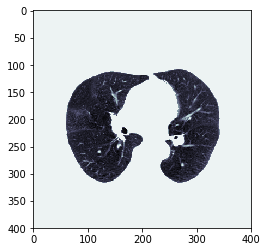

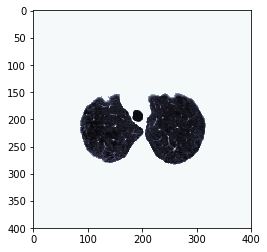

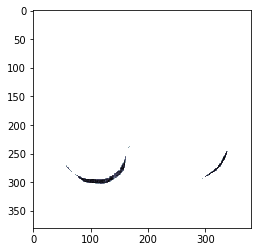

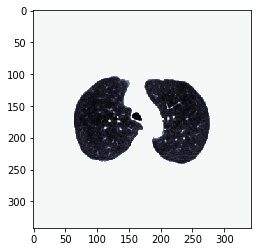

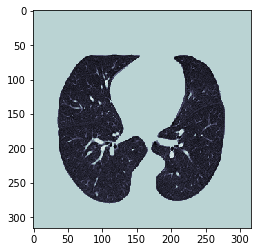

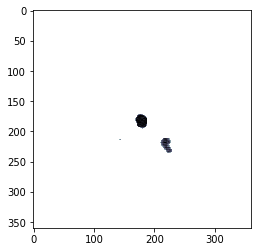

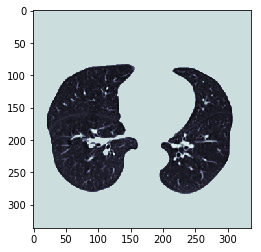

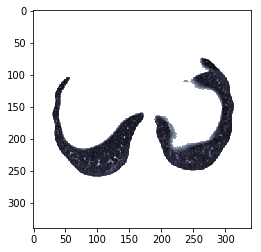

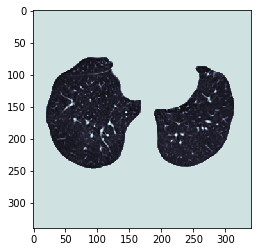

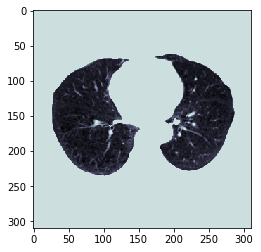

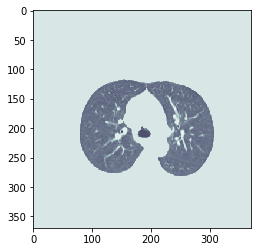

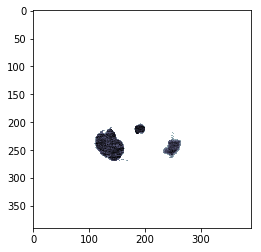

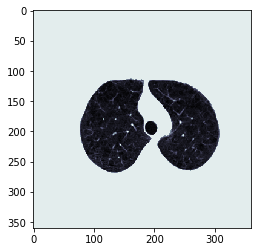

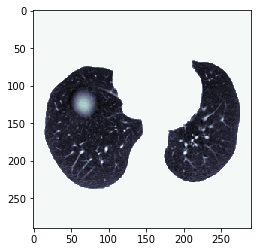

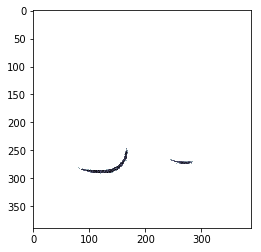

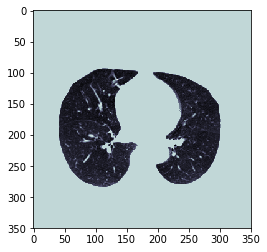

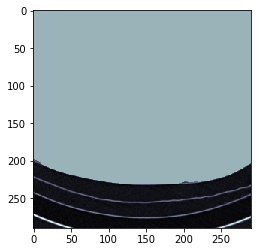

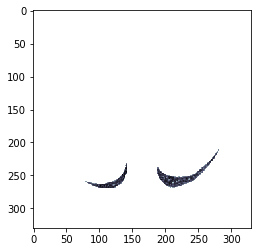

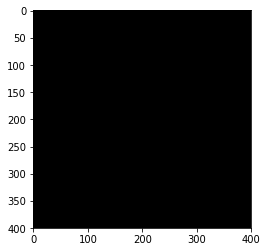

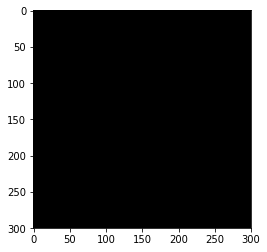

In [68]:
def plot_2d(im):
    # Show some slice in the middle
    plt.imshow(im, cmap=plt.cm.bone)
    plt.show()

for patient_id in test_ids[0:20]:
    scans = np.load(stage1_processed + "scan_segmented_lungs_fill_" + patient_id + ".npy" )
    # Show some slice in the middle
    random_slice_index = int(np.random.random() * len(scans))
    plot_2d(scans[random_slice_index])

## Plotting

Let's plot one patient (patient[0]) to see what the data looks like

In [69]:
def plot_3d(image, threshold=-300):
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
#     ax.invert_zaxis()

    plt.show()

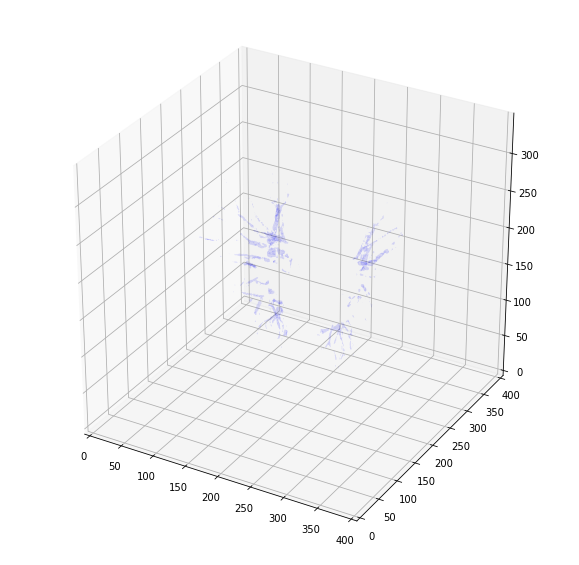

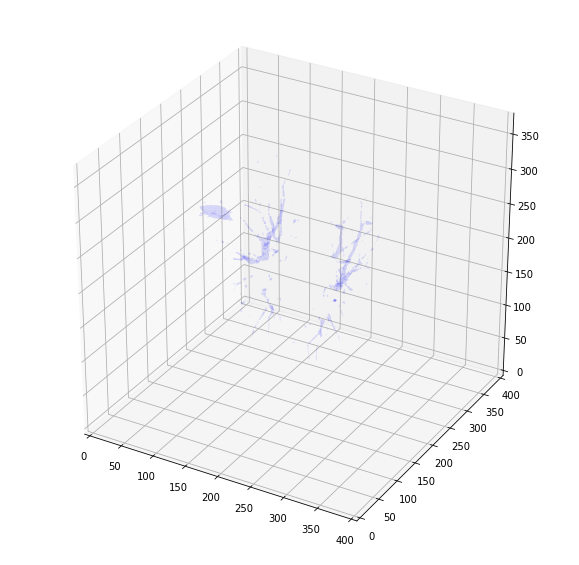

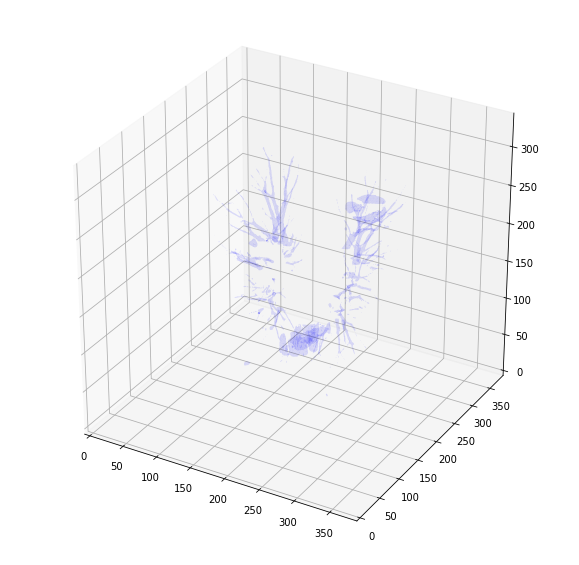

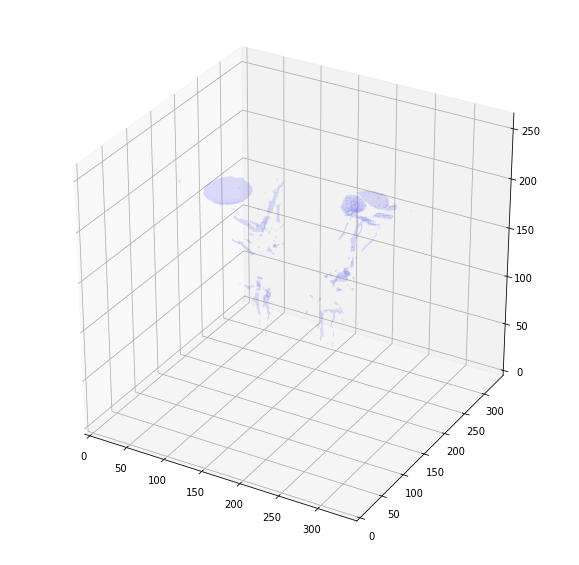

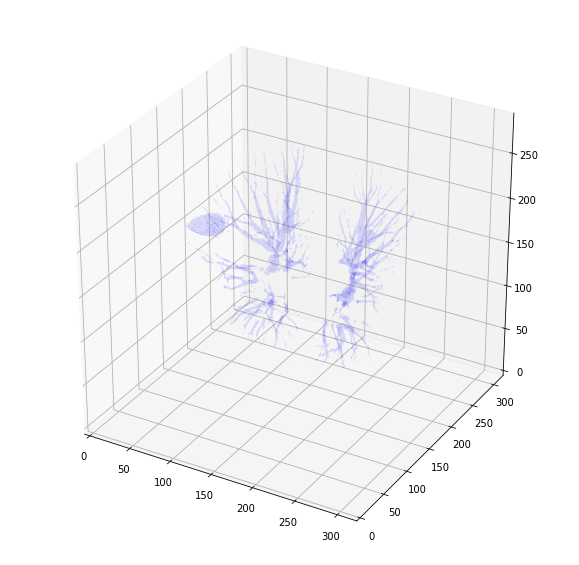

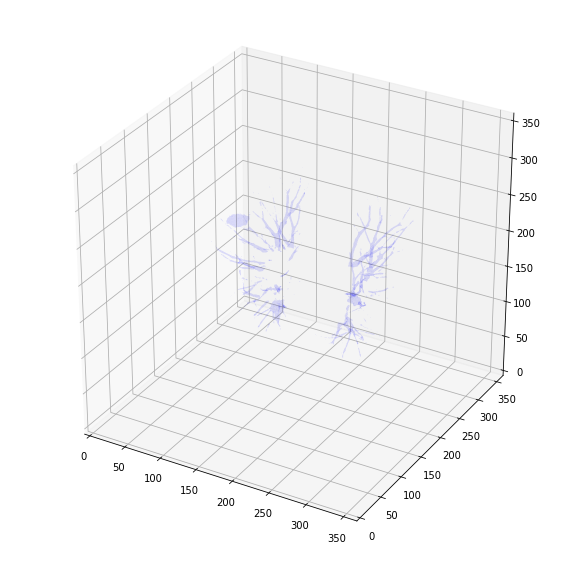

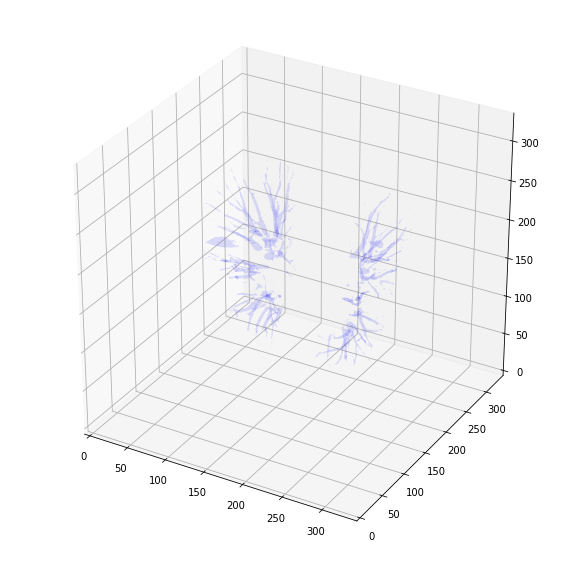

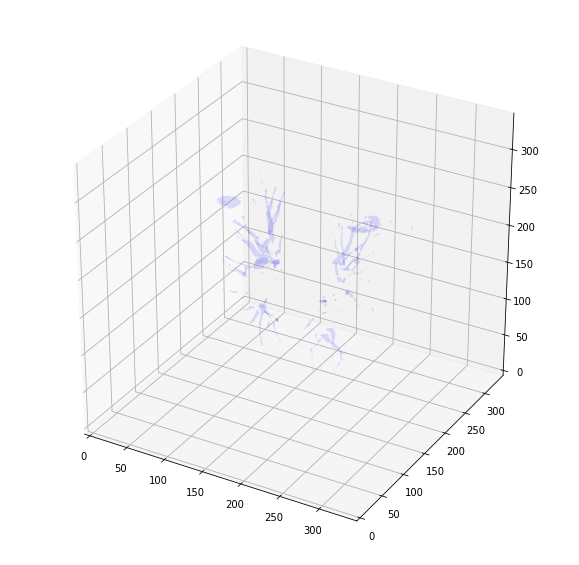

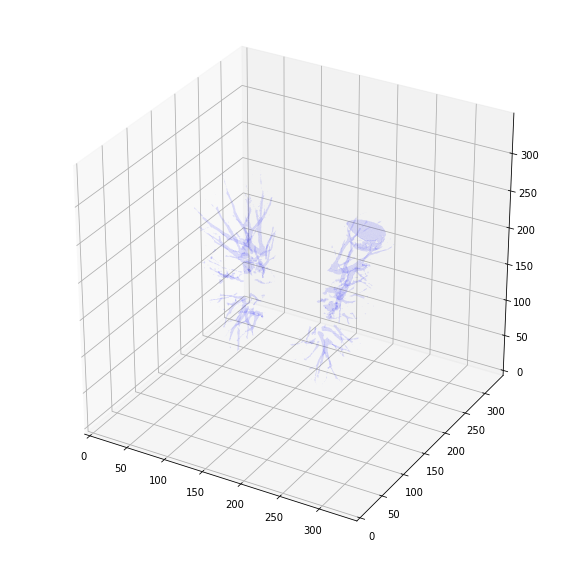

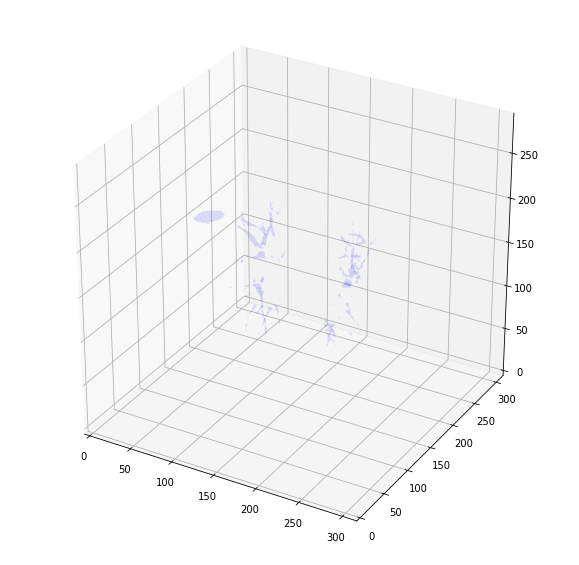

In [70]:
for patient_id in test_ids[0:10]:
    #print(stage1_labels.loc[stage1_labels['id'] == patient_id])
#     print(scan_segmented_lungs_fill[patient_id].shape)
#     print(np.mean(scan_segmented_lungs_fill[patient_id]))
    plot_3d(scan_segmented_lungs_fill[patient_id], 0)